In [180]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["HUGGINGFACE_API_KEY"] = os.getenv("HUGGINGFACE_API_KEY")

In [181]:
from langchain_groq import ChatGroq
llm = ChatGroq(model_name="openai/gpt-oss-120b")

In [182]:
from langchain_core.tools import tool

In [183]:
from langchain_tavily import TavilySearch

In [184]:
@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers together."""
    return a * b

In [185]:
multiply.invoke({"a":2, "b": 4})

8

In [186]:
@tool
def search(query: str):
    """Search the web for a query."""
    tavily = TavilySearch()
    result = tavily.invoke(query)
    return result

In [187]:
tools = [search, multiply]

In [188]:
llm_with_tools = llm.bind_tools(tools)

In [189]:
result = llm_with_tools.invoke("What is the current gdp of india?")

In [190]:
result.content

''

In [191]:
result.tool_calls

[{'name': 'search',
  'args': {'query': 'current GDP of India 2024'},
  'id': 'fc_4f4da3cf-8dee-4f86-bba5-a6a22ee739be',
  'type': 'tool_call'}]

In [192]:
result.tool_calls[0]

{'name': 'search',
 'args': {'query': 'current GDP of India 2024'},
 'id': 'fc_4f4da3cf-8dee-4f86-bba5-a6a22ee739be',
 'type': 'tool_call'}

In [193]:
result.tool_calls[0]["name"]

'search'

In [194]:
result.tool_calls[0]["args"]

{'query': 'current GDP of India 2024'}

In [195]:
tool_mapping = {tool.name:tool for tool in tools}

In [196]:
tool_mapping

{'search': StructuredTool(name='search', description='Search the web for a query.', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000002243E0899E0>),
 'multiply': StructuredTool(name='multiply', description='Multiply two numbers together.', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x000002243E088860>)}

In [197]:
tool_mapping["search"]

StructuredTool(name='search', description='Search the web for a query.', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000002243E0899E0>)

In [198]:
tool_mapping["multiply"].invoke({"a":2, "b":3})

6

In [199]:
tool_mapping[result.tool_calls[0]["name"]].invoke(result.tool_calls[0]["args"])

{'query': 'current GDP of India 2024',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://tradingeconomics.com/india/gdp',
   'title': 'India GDP',
   'content': 'The Gross Domestic Product (GDP) in India was worth 3912.69 billion US dollars in 2024, according to official data from the World Bank.',
   'score': 0.9229352,
   'raw_content': None},
  {'url': 'https://www.worldometers.info/gdp/india-gdp/',
   'title': 'India GDP (2025)',
   'content': 'Gross Domestic Product (GDP) of India ; 2024, $3,909,892,000,000, 6.5% ; 2023, $3,638,490,000,000, 9.2% ; 2022, $3,346,107,000,000, 7.6% ; 2021, $3,167,271,000,000',
   'score': 0.902481,
   'raw_content': None},
  {'url': 'https://www.worldeconomics.com/GrossDomesticProduct/Real-GDP/India.aspx',
   'title': 'India Real GDP 2025',
   'content': "India GDP Forecast: 3,425bn in 2024, $3,646bn projected for 2025 (Constant 2015 Prices). Looking ahead to 2030, projections suggest India's GDP estimate",
  

In [200]:
from typing import TypedDict, Sequence, Annotated
import operator
from langchain_core.messages import BaseMessage, ToolMessage
from langgraph.graph.message import add_messages

from langgraph.checkpoint.memory import MemorySaver

In [201]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [202]:
# state = {"messages":["hi","how are you?"]}

In [203]:
def invoke_model(state: AgentState):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

In [204]:
def router(state: AgentState):
    tool_call = state["messages"][-1].tool_calls
    if tool_call:
        return "tool"
    return "end"

In [205]:
def invoke_tool(state: AgentState):
    tool_details = state["messages"][-1].tool_calls
    if not tool_details:
        raise ValueError("No tool call found")
    print(f"Selected tool: {tool_details[0]['name']}")
    response = tool_mapping[tool_details[0]["name"]].invoke(tool_details[0]["args"])

    response = ToolMessage(tool_call_id=tool_details[0]["id"], content=str(response), name=tool_details[0]["name"])
    return {"messages": [response]}


In [206]:
tools

[StructuredTool(name='search', description='Search the web for a query.', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000002243E0899E0>),
 StructuredTool(name='multiply', description='Multiply two numbers together.', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x000002243E088860>)]

In [207]:
from langgraph.graph import StateGraph, START, END

In [208]:
graph = StateGraph(AgentState)

#### earlier we are using the tool node from the list of tool
#### but now we have create tool invoke(cusotm function)
#### as a user if we want to take a authority to which tool I need to give permission for execution

In [209]:
graph.add_node("ai_assistant", invoke_model)
graph.add_node("tool", invoke_tool)

In [210]:
graph.add_conditional_edges(
    "ai_assistant",
    router,
    {
        "tool": "tool",
        "end": END,
    }
)

In [211]:
graph.add_edge(START, "ai_assistant")

In [212]:
graph.add_edge("tool", END)

In [213]:
memory = MemorySaver()
app = graph.compile(checkpointer=memory, interrupt_before=["tool"])

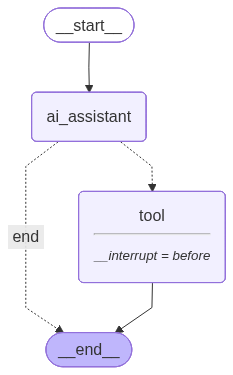

In [214]:
app

In [215]:
config = {"configurable": {"thread_id": "1"}}
app.invoke({"messages":[("user", "what is the current GDP of India?")]}, config=config)

{'messages': [HumanMessage(content='what is the current GDP of India?', additional_kwargs={}, response_metadata={}, id='ede6f9e2-2f8f-46a8-ab66-f6ca96c17dbf'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'User asks: "what is the current GDP of India?" Need latest data. As of 2026? Need to browse web. Use search tool.', 'tool_calls': [{'id': 'fc_61c332ce-5ce8-4a18-ab94-a807b24c9c25', 'function': {'arguments': '{"query":"India GDP 2025 current GDP 2025 India nominal GDP 2025"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 73, 'prompt_tokens': 150, 'total_tokens': 223, 'completion_time': 0.154328806, 'completion_tokens_details': {'reasoning_tokens': 32}, 'prompt_time': 0.006384157, 'prompt_tokens_details': None, 'queue_time': 0.045747803, 'total_time': 0.160712963}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_d29d1d1418', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None

In [216]:
app.invoke({"messages":[("user", "what is the 40 * 5?")]}, config=config)

{'messages': [HumanMessage(content='what is the current GDP of India?', additional_kwargs={}, response_metadata={}, id='ede6f9e2-2f8f-46a8-ab66-f6ca96c17dbf'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'User asks: "what is the current GDP of India?" Need latest data. As of 2026? Need to browse web. Use search tool.', 'tool_calls': [{'id': 'fc_61c332ce-5ce8-4a18-ab94-a807b24c9c25', 'function': {'arguments': '{"query":"India GDP 2025 current GDP 2025 India nominal GDP 2025"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 73, 'prompt_tokens': 150, 'total_tokens': 223, 'completion_time': 0.154328806, 'completion_tokens_details': {'reasoning_tokens': 32}, 'prompt_time': 0.006384157, 'prompt_tokens_details': None, 'queue_time': 0.045747803, 'total_time': 0.160712963}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_d29d1d1418', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None

In [217]:
app.invoke({"messages":[("user", "what is the weather in delhi?")]}, config=config)

{'messages': [HumanMessage(content='what is the current GDP of India?', additional_kwargs={}, response_metadata={}, id='ede6f9e2-2f8f-46a8-ab66-f6ca96c17dbf'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'User asks: "what is the current GDP of India?" Need latest data. As of 2026? Need to browse web. Use search tool.', 'tool_calls': [{'id': 'fc_61c332ce-5ce8-4a18-ab94-a807b24c9c25', 'function': {'arguments': '{"query":"India GDP 2025 current GDP 2025 India nominal GDP 2025"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 73, 'prompt_tokens': 150, 'total_tokens': 223, 'completion_time': 0.154328806, 'completion_tokens_details': {'reasoning_tokens': 32}, 'prompt_time': 0.006384157, 'prompt_tokens_details': None, 'queue_time': 0.045747803, 'total_time': 0.160712963}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_d29d1d1418', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None

## langgraph inbuilt human in loop


In [218]:
tools

[StructuredTool(name='search', description='Search the web for a query.', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000002243E0899E0>),
 StructuredTool(name='multiply', description='Multiply two numbers together.', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x000002243E088860>)]

In [219]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [220]:
llm_with_tools = llm.bind_tools(tools)

In [221]:
def ai_assistant(state: AgentState):
    llm_response = llm_with_tools.invoke(state["messages"])
    return {"messages": [llm_response]}

In [222]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [223]:
from langgraph.prebuilt import ToolNode, tools_condition

In [224]:
tool_node = ToolNode(tools)

In [225]:
graph = StateGraph(AgentState)

In [226]:
graph.add_node("ai_assistant", ai_assistant)

In [227]:
graph.add_node("tools", tool_node)

In [228]:
graph.add_edge(START, "ai_assistant")


In [229]:
graph.add_conditional_edges(
    "ai_assistant", 
    tools_condition,
    )

In [230]:
graph.add_edge("tools", "ai_assistant")

In [231]:
app = graph.compile(checkpointer=memory, interrupt_before=["tools"])

### It is going to interrupt before the tool call

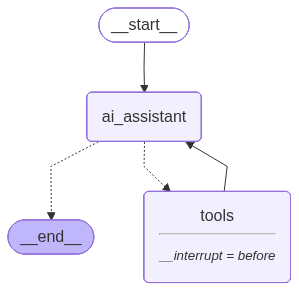

In [232]:
app

In [233]:
config = {"configurable": {"thread_id": "1"}}

In [234]:
response = app.invoke({"messages":[("user", "what is the weather in delhi")]}, config=config)

In [235]:
app.invoke(None, config)  # reusme the last state or resume the process

{'messages': [HumanMessage(content='what is the weather in delhi', additional_kwargs={}, response_metadata={}, id='781f757a-65da-4e96-9e21-e6f6f30772aa'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'The user asks "what is the weather in delhi". We need current weather. We can use web search. Use function search with query "Delhi weather".', 'tool_calls': [{'id': 'fc_8a4582ca-4e7a-4d3b-8a19-ab9ce143dce1', 'function': {'arguments': '{"query":"Delhi weather"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 60, 'prompt_tokens': 149, 'total_tokens': 209, 'completion_time': 0.133186281, 'completion_tokens_details': {'reasoning_tokens': 33}, 'prompt_time': 0.007178514, 'prompt_tokens_details': None, 'queue_time': 0.045910073, 'total_time': 0.140364795}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_e10890e4b9', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider'

In [236]:
tool_details = response["messages"][-1].tool_calls

In [237]:
tool_details[0]["name"]

'search'

In [238]:
snapshot = app.get_state(config)
if snapshot.next:
    app.invoke(None, config)

In [239]:
thread_config = {"configurable": {"thread_id": "1"}}
initial_input = {"messages": [("user", "What is the GDP of India?")]}

# First run - stops before tool
print("--- Starting Graph ---")
for event in app.stream(initial_input, thread_config, stream_mode="values"):
    event["messages"][-1].pretty_print()

print("\n--- Graph Paused (Interrupt) ---")
print("Reviewing state...")
snapshot = app.get_state(thread_config)
if snapshot.next:
    print(f"Next step: {snapshot.next}")

# Resume graph
print("\n--- Resuming Graph ---")
for event in app.stream(None, thread_config, stream_mode="values"):
    event["messages"][-1].pretty_print()

--- Starting Graph ---
================================ Human Message =================================

What is the GDP of India?
================================== Ai Message ==================================
Tool Calls:
  search (fc_5f88ed15-e684-4cae-8d1e-c624376e61d9)
 Call ID: fc_5f88ed15-e684-4cae-8d1e-c624376e61d9
  Args:
    query: India GDP 2025 nominal

--- Graph Paused (Interrupt) ---
Reviewing state...
Next step: ('tools',)

--- Resuming Graph ---
================================== Ai Message ==================================
Tool Calls:
  search (fc_5f88ed15-e684-4cae-8d1e-c624376e61d9)
 Call ID: fc_5f88ed15-e684-4cae-8d1e-c624376e61d9
  Args:
    query: India GDP 2025 nominal
================================= Tool Message =================================
Name: search

{"query": "India GDP 2025 nominal", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.worldometers.info/gdp/india-gdp/", "title": "India GDP (2025)", "content": 